<a href="https://colab.research.google.com/github/ontenkutsenko/DL_Skin_Disease_Classification/blob/main/VersionWithFunctionsGithub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import tensorflow_addons as tfa

import pickle

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50, VGG16, VGG19, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

from collections import Counter

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import time

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

#### Sorting the images into separate train-val-test folders

In [6]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

Our dataset contains information of skin color, which may be really important in case of Computer Vision task. We don't want our model to be biased, so we will stratify data in train, validation and test not only by label, but by every skin color, using fitzpatrick_scale. It will help to achieve better generalization and make validation stage more reliable

In [7]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [8]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [9]:
# Proportions do not exactly match what we defined because of rare skin color and class combinations that

proportion = {
    'train': 0.70,
    'val': 0.10,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

split
train    0.687712
test     0.188800
val      0.123488
Name: count, dtype: float64

In [25]:
source_folder = "images/Images for project"
destination_folder = "dataset"


for i in range(len(df)):
    try:
        source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
        destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
        os.makedirs(os.path.dirname(destination_file), exist_ok=True)
        shutil.move(source_file, destination_file)
    except:
        print(source_file, ' doesn\'t exist')

images/Images for project/epidermolysis_bullosa_simplex9.jpg  doesn't exist
images/Images for project/eczema_eyelids9.jpg  doesn't exist
images/Images for project/allergic_contact_dermatitis36.jpg  doesn't exist
images/Images for project/erythema_multiforme120.jpg  doesn't exist
images/Images for project/img?imageId=3005  doesn't exist
images/Images for project/drug_eruption139.jpg  doesn't exist
images/Images for project/erythema_multiforme149.jpg  doesn't exist
images/Images for project/kekoid50.jpg  doesn't exist
images/Images for project/mycosis-fongoide69.jpg  doesn't exist
images/Images for project/img?imageId=5067  doesn't exist
images/Images for project/eczema_atopic6.jpg  doesn't exist
images/Images for project/herpes_gestationis12.jpg  doesn't exist
images/Images for project/sun-damaged-skin6.jpg  doesn't exist
images/Images for project/ehlers_danlos_syndrome39.jpg  doesn't exist
images/Images for project/parapsoriasis-large-plaque13.jpg  doesn't exist
images/Images for proje

# Define Data Generators (Rest comes when we compile and train)

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating Callbacks

In [27]:
# As skin disease task might be very complex we want to measure simple accuracy
# But Top_n accuracy (meaning we check if there is correct prediction among top N predictions we make)

def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(np.argsort(y_val, axis = 1)[:,-1:] - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)


class TopNAccuracyCallback(Callback):
  def __init__(self, val_generator):
      super().__init__()
      self.val_generator = val_generator

  def on_epoch_end(self, epoch, logs=None):
      start_time = time.time()
      top_1_acc = []
      top_3_acc = []
      top_5_acc = []
      for x_val_batch, y_val_batch in self.val_generator:
        val_predictions = self.model.predict(x_val_batch, verbose = 0)
        top_1_acc.append(top_n_accuracy(y_val_batch, val_predictions, 1))
        top_3_acc.append(top_n_accuracy(y_val_batch, val_predictions, 3))
        top_5_acc.append(top_n_accuracy(y_val_batch, val_predictions, 5))
        if len(top_1_acc) >= len(self.val_generator):
          break
      end_time = time.time()
      duration = end_time - start_time
      print(f'Top-1 accuracy: {np.mean(top_1_acc):.3f}, Top-3 accuracy: {np.mean(top_3_acc):.3f}, Top-5 accuracy: {np.mean(top_5_acc):.3f}, \nTime to calculate: {duration:.2f} seconds')

In [36]:
class PlotMetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.weighted_f1 = []
        self.val_weighted_f1 = []

    def on_epoch_end(self, epoch, logs):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))
        self.weighted_f1.append(logs.get('weighted_f1'))
        self.val_weighted_f1.append(logs.get('val_weighted_f1'))

        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.plot(range(1, epoch + 2), self.losses, label='Training Loss', color='blue', linestyle='-')
        plt.plot(range(1, epoch + 2), self.val_losses, label='Validation Loss', color='red', linestyle='-.')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.plot(range(1, epoch + 2), self.accuracies, label='Training Accuracy', color='blue', linestyle='-')
        plt.plot(range(1, epoch + 2), self.val_accuracies, label='Validation Accuracy', color='red', linestyle='-.')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.plot(range(1, epoch + 2), self.weighted_f1, label='Training Weighted F1', color='blue', linestyle='-')
        plt.plot(range(1, epoch + 2), self.val_weighted_f1, label='Validation Weighted F1', color='red', linestyle='-.')
        plt.xlabel('Epochs')
        plt.ylabel('Weighted F1')
        plt.title('Training and Validation Weighted F1')
        plt.legend()

        plt.tight_layout()
        plt.show()

# To plot metrics every epoch
plot_metrics_callback = PlotMetricsCallback()

In [28]:
# define here also metric of f1 weighted and macro
weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1')
macro_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'macro', name = 'macro_f1')

2024-04-27 21:56:57.884983: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 21:56:57.885385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 21:56:57.885697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [30]:
# Creatings instances

# To stop training if validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# To save weights of the model with best accuracy
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# To reduce learning rate if validation loss do not improve several epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# To clear plot every epoch
clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)

# Creating the Model

In [44]:
# reusable function
def compile_and_train_model(base_model, optimizer, trainable=4, batch_size=128, epochs=30, use_class_weights=False, input_size = (128,128)):
    for layer in base_model.layers[:-trainable]:
        layer.trainable = False

    train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        target_size=input_size)

    val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size=input_size)

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', weighted_f1_score, macro_f1_score])

    # instance for top_n_accuracy
    top_n_accuracy_callback = TopNAccuracyCallback(val_generator)

    callbacks = [reduce_lr, early_stopping, model_checkpoint, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback]

    if use_class_weights:
        class_weights = dict(enumerate(compute_class_weight('balanced',
                                                            classes=np.unique(train_generator.classes),
                                                            y=train_generator.classes)))
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(val_generator),
                            class_weight=class_weights,
                            callbacks=callbacks,
                            verbose=1)
    else:
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_steps=len(val_generator),
                            callbacks=callbacks, verbose=1)

    return model, history

In [32]:
#Function to compare covergence with different parameters

def plot_comparison(history, labels):
  val_accuracies = []
  for i in history:
      val_accuracies.append(i['val_accuracy'])

  plt.figure(figsize=(16, 5))
  for j in range(len(val_accuracies)):
      plt.subplot(1, 2, 1)
      plt.plot(range(1, len(val_accuracies[j]) + 1), val_accuracies[j], label=labels[j],  linestyle='-')

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy')
  plt.legend()

  val_f1 = []
  for i in history:
      val_f1.append(i['val_weighted_f1'])

  for j in range(len(val_f1)):
      plt.subplot(1, 2, 2)
      plt.plot(range(1, len(val_f1[j]) + 1), val_f1[j], label=labels[j],  linestyle='-')

  plt.subplot(1, 2, 2)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.xlabel('Epochs')
  plt.ylabel('Weighted F1')
  plt.title('Validation Weighted F1')
  plt.legend()
  plt.show()

## Model Comparison (effnet, resnet and vgg19)

#### EfficientNetB0

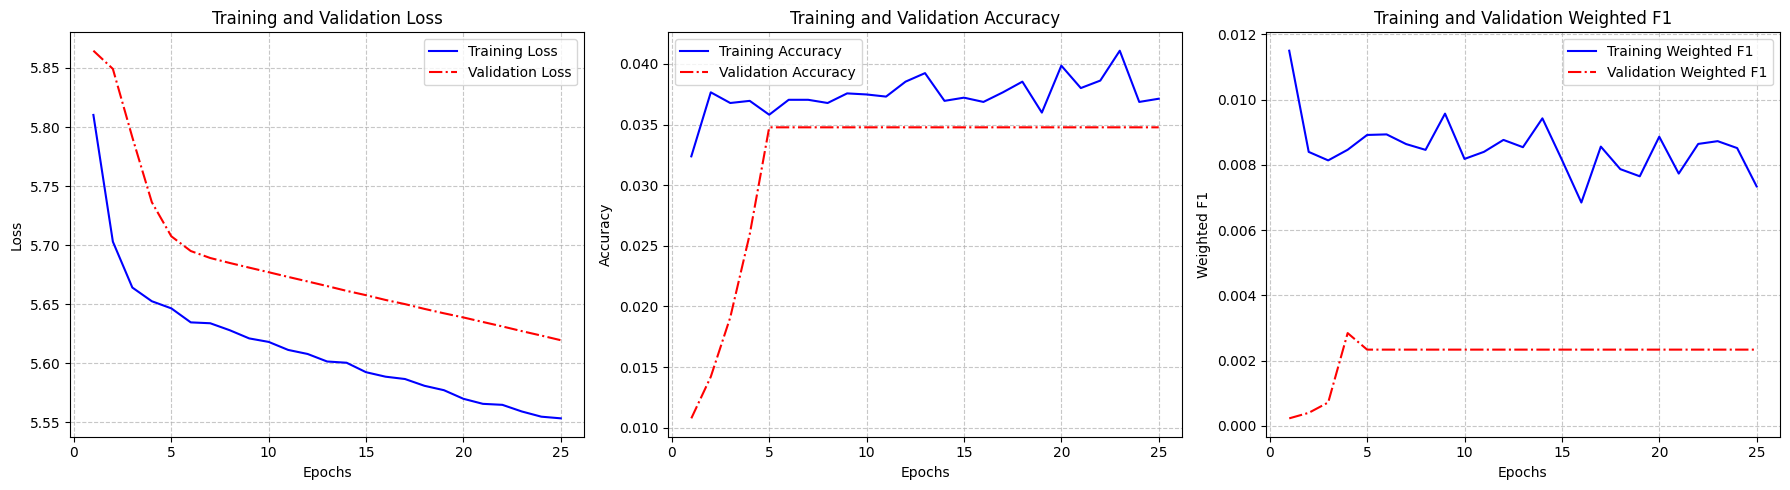

Top-1 accuracy: 0.035, Top-3 accuracy: 0.090, Top-5 accuracy: 0.137, 
Time to calculate: 8.17 seconds
89/89 [==============================] - 83s 934ms/step - loss: 5.5534 - accuracy: 0.0371 - weighted_f1: 0.0073 - macro_f1: 0.0019 - val_loss: 5.6195 - val_accuracy: 0.0348 - val_weighted_f1: 0.0023 - val_macro_f1: 5.8950e-04 - lr: 0.0010
Epoch 26/30
14/89 [===>..........................] - ETA: 57s - loss: 5.5439 - accuracy: 0.0357 - weighted_f1: 0.0089 - macro_f1: 0.0023

KeyboardInterrupt: 

In [49]:
# Lets try effnetb0
base_model = EfficientNetB0(include_top=False, input_shape=(128, 128, 3))
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)

effnet, history_effnet = compile_and_train_model(base_model, sgd_optimizer, trainable=4, batch_size=128, epochs=30, use_class_weights=False, input_size=(128,128))

#### VGG19

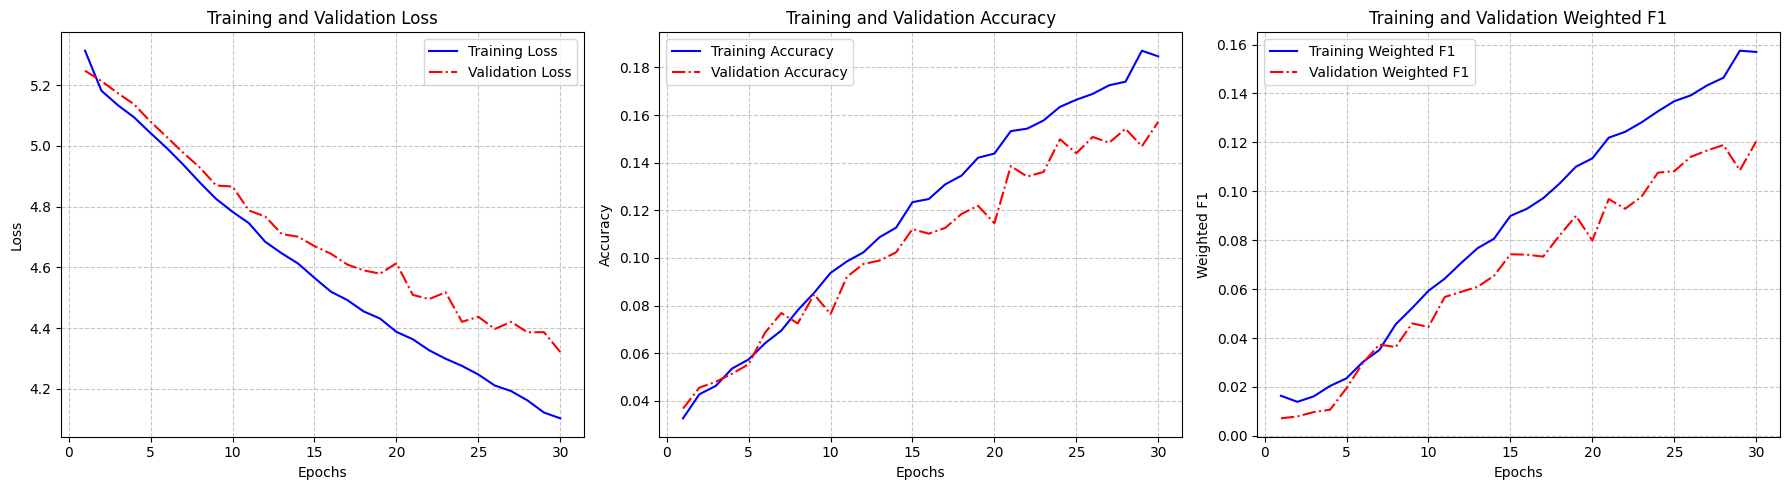

Top-1 accuracy: 0.157, Top-3 accuracy: 0.292, Top-5 accuracy: 0.388, 
Time to calculate: 7.68 seconds
89/89 [==============================] - 83s 929ms/step - loss: 4.1028 - accuracy: 0.1847 - weighted_f1: 0.1570 - macro_f1: 0.1197 - val_loss: 4.3212 - val_accuracy: 0.1572 - val_weighted_f1: 0.1204 - val_macro_f1: 0.0900 - lr: 0.0010


In [47]:
# Try VGG19 
base_model = VGG19(include_top=False, input_shape=(128, 128, 3))
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)

vgg19, history_vgg19 = compile_and_train_model(base_model, sgd_optimizer, trainable=4, batch_size=128, epochs=30, use_class_weights=False, input_size=(128,128))

#### RESNET50

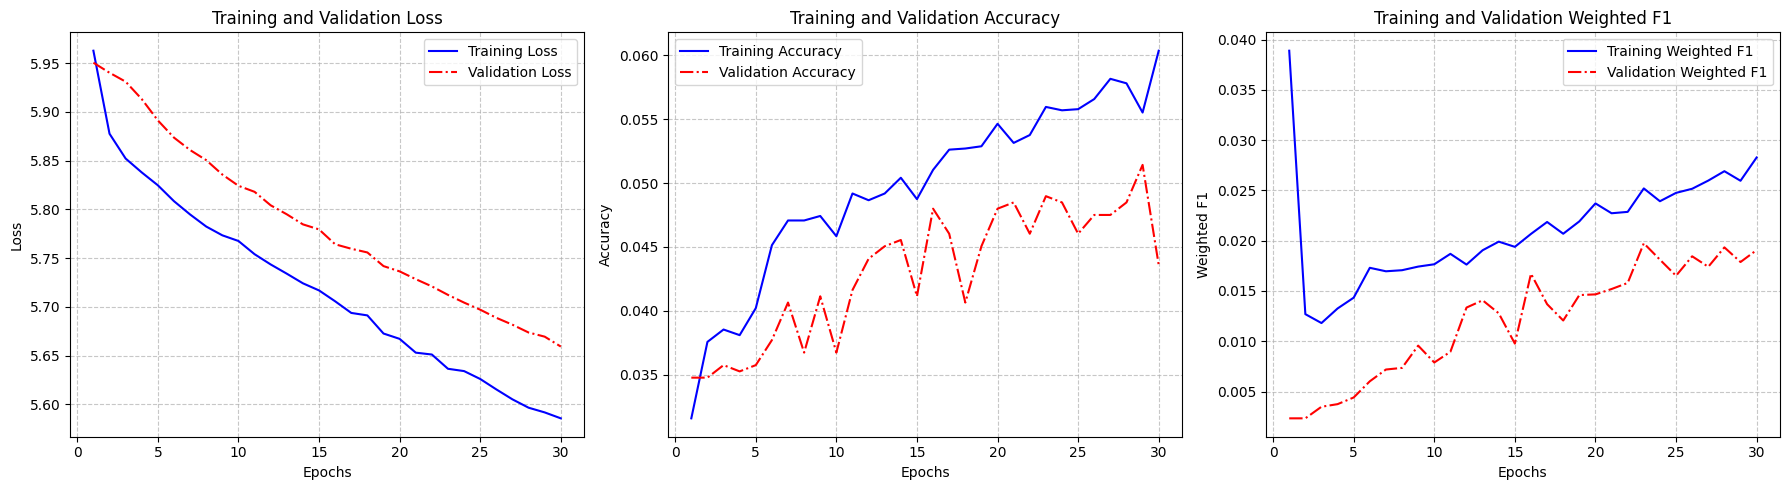

Top-1 accuracy: 0.044, Top-3 accuracy: 0.117, Top-5 accuracy: 0.180, 
Time to calculate: 8.04 seconds
89/89 [==============================] - 83s 930ms/step - loss: 5.5858 - accuracy: 0.0604 - weighted_f1: 0.0283 - macro_f1: 0.0121 - val_loss: 5.6594 - val_accuracy: 0.0436 - val_weighted_f1: 0.0191 - val_macro_f1: 0.0101 - lr: 0.0010


In [48]:
# Try ResNet50
base_model = ResNet50(include_top=False, input_shape=(128, 128, 3))
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)

resnet, history_resnet = compile_and_train_model(base_model, sgd_optimizer, trainable=4, batch_size=128, epochs=30, use_class_weights=False, input_size=(128,128))

#### VGG16

In [ ]:
# Use vgg16
base_model = VGG16(include_top=False, input_shape=(128, 128, 3))

sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)

vgg16, history_vgg16 = compile_and_train_model(base_model, sgd_optimizer, trainable=4, batch_size=128, epochs=30, use_class_weights=False, input_size=(128,128))

#### Self Made Model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),   # used instead of flatten
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(114, activation='softmax')
])

sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=sgd_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy', weighted_f1_score, macro_f1_score])

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    batch_size=128,
    shuffle=True,
    class_mode='categorical',
    target_size=(128,128))

val_generator = val_datagen.flow_from_directory(
    'dataset/val',
    batch_size=128,
    class_mode='categorical',
    target_size=(128,128))

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=30,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint, clear_output_callback, plot_metrics_callback],
                    verbose=1)

In [51]:
history_effnet.history

{'loss': [5.9073309898376465,
  5.888430118560791,
  5.883322715759277,
  5.875448703765869,
  5.871917247772217,
  5.862868785858154,
  5.860057353973389,
  5.8555402755737305,
  5.852418899536133,
  5.844893932342529,
  5.83876371383667,
  5.837860107421875,
  5.832355499267578,
  5.826034069061279,
  5.822087287902832,
  5.818713665008545,
  5.814368724822998,
  5.812203884124756,
  5.807713031768799,
  5.802541732788086,
  5.797754764556885,
  5.793592929840088,
  5.79180383682251,
  5.785818099975586,
  5.7814555168151855,
  5.779545307159424,
  5.773033142089844,
  5.772749423980713,
  5.766371250152588,
  5.761419296264648],
 'accuracy': [0.007038536015897989,
  0.009677986614406109,
  0.009062115103006363,
  0.00941404141485691,
  0.008094316348433495,
  0.008798169903457165,
  0.007126517593860626,
  0.00959000550210476,
  0.007830371148884296,
  0.00959000550210476,
  0.008974133059382439,
  0.00800633430480957,
  0.008358261547982693,
  0.007566426414996386,
  0.008798169903

In [52]:
history_vgg19.history

{'loss': [5.3137030601501465,
  5.1819987297058105,
  5.134462356567383,
  5.093925476074219,
  5.0423197746276855,
  4.992341995239258,
  4.937880516052246,
  4.879888534545898,
  4.825499057769775,
  4.783051490783691,
  4.7456536293029785,
  4.684103488922119,
  4.64639949798584,
  4.612602233886719,
  4.565458297729492,
  4.52012300491333,
  4.4925408363342285,
  4.45503568649292,
  4.431462287902832,
  4.387664794921875,
  4.363321781158447,
  4.326887607574463,
  4.299108028411865,
  4.275600433349609,
  4.2471747398376465,
  4.210997104644775,
  4.192569255828857,
  4.161697864532471,
  4.122034549713135,
  4.102845668792725],
 'accuracy': [0.0326412096619606,
  0.04275910556316376,
  0.046278372406959534,
  0.05358085408806801,
  0.05736406892538071,
  0.06413865834474564,
  0.06950554251670837,
  0.07803976535797119,
  0.08534225076436996,
  0.09370051324367523,
  0.09853950142860413,
  0.10232271999120712,
  0.10874538123607635,
  0.1127045601606369,
  0.12343832850456238,
  

In [54]:
history_resnet.history

{'loss': [5.962833881378174,
  5.8776960372924805,
  5.852229118347168,
  5.837982177734375,
  5.824783802032471,
  5.808497428894043,
  5.794862270355225,
  5.782483100891113,
  5.773478031158447,
  5.767663478851318,
  5.754122257232666,
  5.74359655380249,
  5.734119892120361,
  5.724257469177246,
  5.716953277587891,
  5.705799579620361,
  5.693871974945068,
  5.691335678100586,
  5.672752857208252,
  5.667276859283447,
  5.653129577636719,
  5.651211738586426,
  5.636585235595703,
  5.634213447570801,
  5.626118183135986,
  5.6154327392578125,
  5.605229377746582,
  5.5966715812683105,
  5.591847896575928,
  5.585753440856934],
 'accuracy': [0.03158542886376381,
  0.03756818547844887,
  0.038535986095666885,
  0.03809607774019241,
  0.0402076356112957,
  0.045134611427783966,
  0.0470702089369297,
  0.0470702089369297,
  0.0474221371114254,
  0.04583846405148506,
  0.04918177053332329,
  0.04865387827157974,
  0.04918177053332329,
  0.05041351541876793,
  0.048741862177848816,
  0